# 01 - Exploração inicial dos dados: Kaggle Titanic  

Realizando análise e ajustando os dados faltantes.

## Preparando o ambiente

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rcParams['figure.figsize'] = (12, 7)

## Carregando os dados

In [3]:
titanic = pd.read_csv('https://raw.githubusercontent.com/SalatielBairros/kaggle-titanic/main/data/original/train.csv')
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
teste = pd.read_csv('https://raw.githubusercontent.com/SalatielBairros/kaggle-titanic/main/data/original/test.csv')
teste.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


## Extraindo informações

### Faixas etárias por pronome de tratamento

Uma forma de resolver os faltantes de idade e agrupar as pessoas por faixas etárias pode ser separar o pronome de tratamento utilizado no nome e relacioná-lo à idade.

In [5]:
titles = []
for nome in titanic['Name']:
  titles.append(nome.split(',')[1].split('.')[0].strip())

titanic['title'] = titles
titanic.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

### Andar da Cabine

O número específico da cabine é irrelevante, visto que identifica o usuário e não temos um mapa do navio para identificar a correlação. Portanto retiramos o número e ficamos apenas com a string, alterando, inclusive, o nome da coluna.

In [6]:
titanic.loc[(titanic.Cabin.notnull()), 'Cabin'] = titanic.loc[(titanic.Cabin.notnull()), 'Cabin'].astype(str).str[0]
titanic.rename(columns={'Cabin': 'Floor'}, inplace=True)

In [7]:
titanic['Floor'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Floor, dtype: int64

## Resolvendo os dados omissos

### Identificando os dados

In [8]:
titanic.shape

(891, 13)

In [9]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Floor        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  title        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [10]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Floor          687
Embarked         2
title            0
dtype: int64

Existem 177 idades não informadas e 687 cabines não informadas. Como a solução falta dos dados se comporta também nos dados de teste?

In [11]:
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [12]:
teste.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [13]:
86/418

0.20574162679425836

In [14]:
117/891

0.13131313131313133

In [15]:
327/418

0.7822966507177034

In [16]:
687/891

0.7710437710437711

Como é notável acima, a proporção dos valores faltantes é semelhante entre os dados de treino e teste, indicando que a solução para ambos pode ser parecida.

### Age

Vamos começar analisando as idades não informadas: 

**(1) Qual o perfil dos registros sem idade informada?**

In [17]:
sem_idade = titanic.query("Age.isnull().values")
sem_idade

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Floor,Embarked,title
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,Mr
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Mrs
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,Mr
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C,Mr
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,Miss
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,Mr
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S,Mr


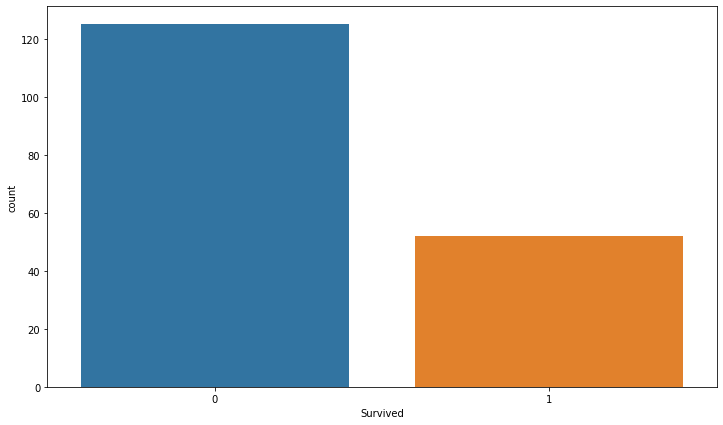

In [18]:
sns.countplot(x='Survived', data=sem_idade);

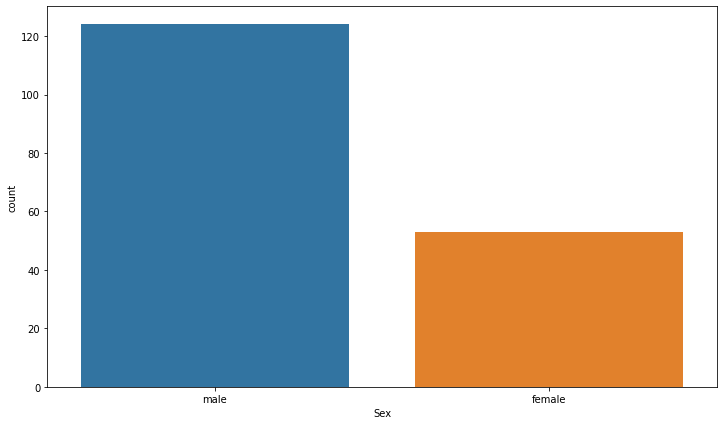

In [19]:
sns.countplot(x='Sex', data=sem_idade);

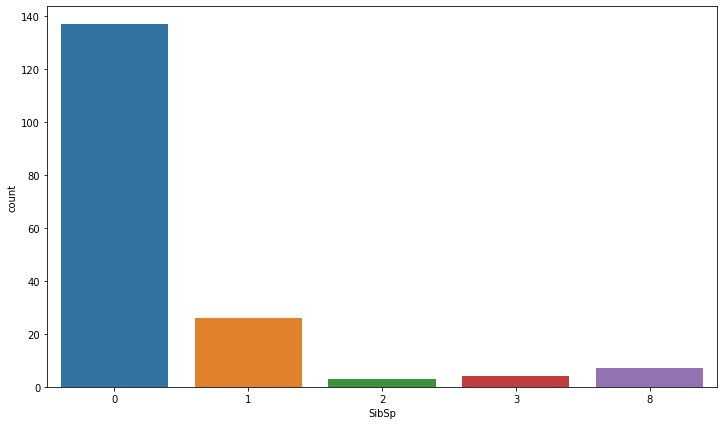

In [20]:
sns.countplot(x='SibSp', data=sem_idade);

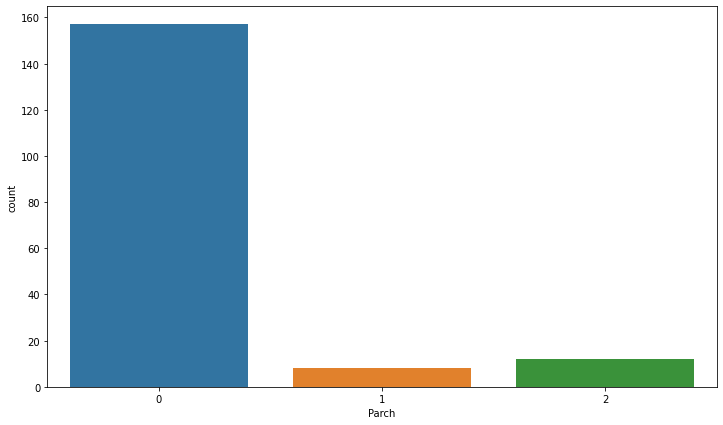

In [21]:
sns.countplot(x='Parch', data=sem_idade);

In [22]:
sem_idade['Floor'].notnull().sum()

19

A maioria dos sem idade estavam sozinhos, eram homens e não sobreviveram. Além disso a maioria também não tinha a cabine informada.

**(2) Como se agrupa a idade pelos pronomes de tratamento?**

In [23]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Floor', 'Embarked', 'title'],
      dtype='object')

In [24]:
titanic.groupby(['title', 'Sex']).Age.describe().sort_values(by='std', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
title,Sex,,,,,,,,
Rev,male,6.0,43.166667,13.136463,27.00,31.500,46.5,53.25,57.0
Miss,female,146.0,21.773973,12.990292,0.75,14.125,21.0,30.00,63.0
Dr,male,5.0,40.600000,12.876335,23.00,32.000,44.0,50.00,54.0
Mr,male,398.0,32.368090,12.708793,11.00,23.000,30.0,39.00,80.0
Mrs,female,108.0,35.898148,11.433628,14.00,27.750,35.0,44.00,63.0
Major,male,2.0,48.500000,4.949747,45.00,46.750,48.5,50.25,52.0
Master,male,36.0,4.574167,3.619872,0.42,1.000,3.5,8.00,12.0
Col,male,2.0,58.000000,2.828427,56.00,57.000,58.0,59.00,60.0
Mlle,female,2.0,24.000000,0.000000,24.00,24.000,24.0,24.00,24.0


In [25]:
pessoa_adulta = ['Rev', 'Dr', 'Mr', 'Major', 'Don', 'Jonkheer', 'Sir', 'Mrs', 'Lady', 'Ms', 'the Countess', 'Col', 'Capt']
mulher_solteira = ['Miss', 'Mlle', 'Mme']
menino_crianca = ['Master']

In [26]:
faixa_etaria = []
for title in titanic['title']:
  if (title in menino_crianca):
    faixa_etaria.append('menino_crianca')
  elif (title in mulher_solteira):
    faixa_etaria.append('mulher_solteira')
  else:
    faixa_etaria.append('pessoa_adulta')

titanic['faixa'] = faixa_etaria
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Floor,Embarked,title,faixa
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,pessoa_adulta
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,pessoa_adulta
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,mulher_solteira
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,pessoa_adulta
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,pessoa_adulta


In [27]:
por_faixa = titanic.groupby(['faixa']).Age.describe()
por_faixa

,count,mean,std,min,25%,50%,75%,max
faixa,,,,,,,,
menino_crianca,36.0,4.574167,3.619872,0.42,1.0,3.5,8.0,12.0
mulher_solteira,149.0,21.818792,12.861787,0.75,14.5,21.0,30.0,63.0
pessoa_adulta,529.0,33.628544,12.715473,11.00,24.0,31.0,42.0,80.0


In [28]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Floor', 'Embarked', 'title', 'faixa'],
      dtype='object')

In [29]:
sem_idade = titanic.query("Age.isnull().values")
sem_idade.groupby(['faixa']).describe()

PassengerId              ...       Fare          
                      count        mean  ...        75%       max
faixa                                    ...                     
menino_crianca          4.0  278.250000  ...  36.487525   69.5500
mulher_solteira        36.0  396.694444  ...  23.625000  110.8833
pessoa_adulta         137.0  450.394161  ...  24.150000  227.5250

[3 rows x 56 columns]

In [30]:
def preenche_idade_por_faixa(nome_faixa):
  mc = por_faixa.query(f"faixa == '{nome_faixa}'")
  i = int((mc['mean'] - (mc['std'])).values[0] + 1)
  f = int((mc['mean'] + (mc['std'])).values[0] - 1)
  n = len(titanic.loc[(titanic.Age.isnull()) & (titanic.faixa == nome_faixa)])
  values = np.random.randint(i, f, n)
  titanic.loc[(titanic.Age.isnull()) & (titanic.faixa == nome_faixa), 'Age'] = values

In [31]:
preenche_idade_por_faixa('menino_crianca')
preenche_idade_por_faixa('mulher_solteira')
preenche_idade_por_faixa('pessoa_adulta')

In [34]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Floor          687
Embarked         2
title            0
faixa            0
dtype: int64

Alterando as idades para o valor inteiro, pois os decimais das idades das crianças menores de um ano não tem grande relevância.

In [38]:
titanic['Age'] = titanic['Age'].astype(int)

In [41]:
titanic.Age.unique()

array([22, 38, 26, 35, 31, 54,  2, 27, 14,  4, 58, 20, 39, 55, 34, 15, 28,
        8, 40, 19, 18, 33, 66, 42, 43, 21, 24,  3,  7, 49, 29, 65,  5, 11,
       45, 17, 32, 16, 25,  0, 30, 23, 46, 59, 71, 37, 44,  9, 47, 70, 12,
       36, 51,  1, 61, 56, 50, 10, 62, 41, 52, 63, 13, 60, 64, 48, 53, 57,
       80,  6, 74])

Baseado em todas as análises, dividindo pelas possíveis faixas etárias, foram atribuídas as idades baseada no intervalo `[STD - MD, MD, STD + MD]` de forma aleatória.

### Floor

Contém a primeira letra dos dados inicialmente identificados como `Cabin`. O propósito é tentar identificar alguma relação que permita utilizar essa coluna como relevante de alguma forma.

Para isso, vamos criar uma coluna `possui_cabine` para identificar e comparar os registros com e sem cabine informada e identificar se o ato de informar ou não tem alguma relevância nos dados.

In [59]:
titanic['possui_cabine'] = titanic['Floor'].notnull()

In [60]:
com_cabine = titanic[titanic['possui_cabine'] == True]
sem_cabine = titanic[titanic['possui_cabine'] == False]

#### Comparando o andar com a classe

In [61]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Floor', 'Embarked', 'title', 'faixa',
       'possui_cabine'],
      dtype='object')

In [62]:
titanic.Pclass.unique()

array([3, 1, 2])

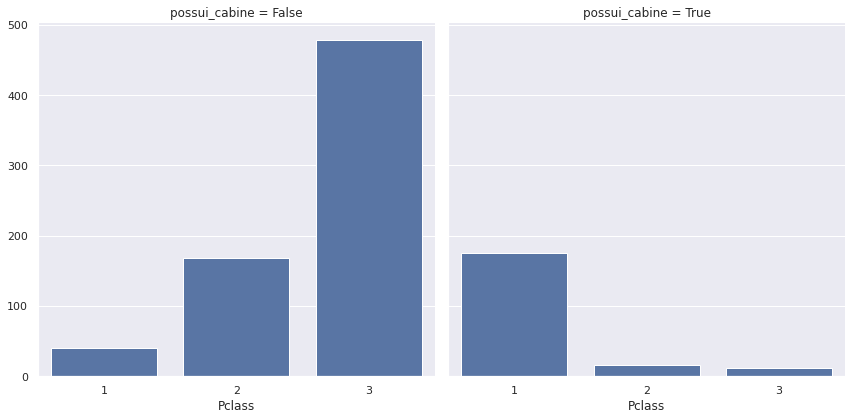

In [66]:
#sns.countplot(x='Pclass', data=com_cabine);
sns.set(style='darkgrid')
g = sns.FacetGrid(titanic, col="possui_cabine", height=6)
g.map(sns.countplot, "Pclass", order=[1, 2, 3]);

Parece existir uma certa correlação entre a classe e ter ou não cabine registrada. A maior parte da primeira classe possui cabine registrada, enquanto uma minoria da terceira classe possui.

Considerando os andares, quantos sobreviveram por andar com relação a quantos tinham?

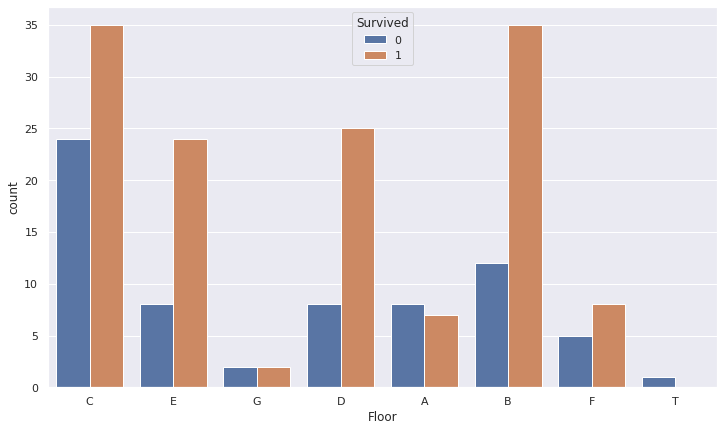

In [71]:
sns.countplot(x = 'Floor', hue='Survived', data=titanic);

Parece existir realmente uma relação entre o andar e sobreviver, ainda que não seja muito relevante e possa acabar viciando os dados. Por hora vamos preencher todos os nulos com `SC`: _sem cabine_ para identificar que possivelmente eles não tinham realmente cabine.

In [74]:
titanic.Floor.fillna('SC', inplace=True)
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Floor            0
Embarked         2
title            0
faixa            0
possui_cabine    0
dtype: int64

### Embarked

Como para este caso existem apenas dois registros não informados vou preencher com o valor mais frequente para esta coluna.

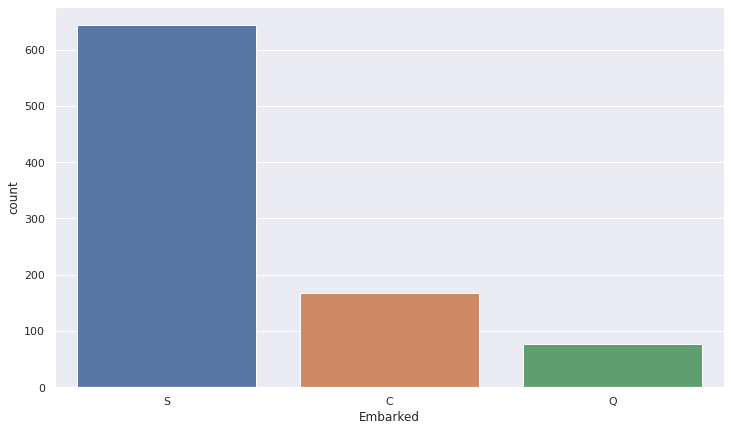

In [76]:
sns.countplot(x = 'Embarked', data=titanic);

In [78]:
titanic.Embarked.fillna('S', inplace=True)
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Floor            0
Embarked         0
title            0
faixa            0
possui_cabine    0
dtype: int64

## Removendo colunas irrelevantes

Algumas informações como `PassagenrId`, `Ticked` e `Name` são irrelevantes para o aprendizado pois são únicos para cada passageiro e podem ser removidos da base de aprendizado. O mesmo deve ser feito posteriormente para o tratamento dos dados de teste.

In [36]:
#titanic.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)